In [3]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import datetime as dt
from scipy import integrate
from sklearn import mixture
import csv

Now I want to figure out how these three factors (change in groundwater level, change in vegetation index, and nitrogen oxide concentrations) are spatially clustered together. Ultimately for the capstone project, I would want to look at the temporal trends in nitrogen oxide concentrations and longer term trends in the vegetation index; however, I limit the scope for this introductory presentation due to the large size of the satellite data output. In the capstone project, I would also like to include other environmental (e.g., flooding frequency, topography) and economic (e.g., temporal changes in prices per square foot) factors. However, for illustration purposes, the analysis here is limited just to the three parameters plotted and discussed above.

I will use Gaussian Mixture Model (GMM) to cluster the data based on these three factors (change in groundwater level, change in vegetation index, and nitrogen oxide concentrations). This model will return data points in groups with similar attributes of these parameters.

Groundwater data has the fewest discrete data points in constrast with the more continuous satellite data. The first step is to extract data points from the satellite vegetation index and nitrogen oxide concentration data that have locations closest to the groundwater data points.

In [29]:
#Extract data points that have the closest latitude and longitude to the groundwater gauge stations
#First for NO2 data
NO2_lst_sm=[]
for i in range(len(gw_tot_df)):
    indNO2 = abs(NO2_df_tot['Lat']-gw_tot_df['Latitude'].to_numpy()[i])*abs(NO2_df_tot['Lon']-gw_tot_df['Longitude'].to_numpy()[i])
    a=indNO2.idxmin()
    NO2_lst_sm.append([gw_tot_df['Latitude'].to_numpy()[i],gw_tot_df['Longitude'].to_numpy()[i],NO2_df_tot['NO2'][a]])
NO2_sm_df = pd.DataFrame(NO2_lst_sm,
                         columns =["Latitude","Longitude",'NO2'])
gw_tot_df["NO2"]=NO2_sm_df['NO2'].to_numpy()

#Then for vegetation index data
VI_sm=[]
latv = lat[80:132]
lonv = lon[100:230]
for i in range(len(gw_tot_df)):
    lat_ind = np.where(abs(latv-gw_tot_df['Latitude'].to_numpy()[i])==abs(latv-gw_tot_df['Latitude'].to_numpy()[i]).min())
    lon_ind = np.where(abs(lonv-gw_tot_df['Longitude'].to_numpy()[i])==abs(lonv-gw_tot_df['Longitude'].to_numpy()[i]).min())
    VI_sm.append([gw_tot_df['Latitude'].to_numpy()[i],gw_tot_df['Longitude'].to_numpy()[i],VI_trend[lat_ind,lon_ind]])
VI_sm_df = pd.DataFrame(VI_sm,
                         columns =["Latitude","Longitude",'VI_trend'])
gw_tot_df["VI_trend"]=VI_sm_df['VI_trend'].to_numpy()  

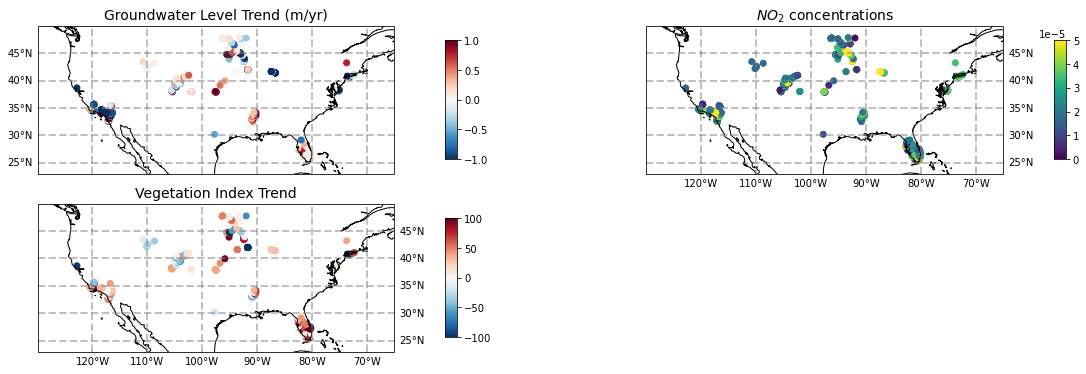

In [32]:
fig = plt.figure()
fig.set_size_inches(20,6)
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())

ax1.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
h=ax1.scatter(gw_tot_df['Longitude'].to_numpy(),gw_tot_df['Latitude'].to_numpy(),
             c=gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy(),vmin=-1,vmax=1,
            cmap='RdBu_r',transform=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
#ax1.set_xlim([-83,-79.5])
#ax1.set_ylim([24.5,30.5])
#gl.xlocator = mticker.FixedLocator([-82,-81,-80])
ax1.set_title('Groundwater Level Trend (m/yr)',fontsize=14)
cb1=plt.colorbar(h,ax=[ax1],pad=0.1,aspect=10,shrink=0.8,location='right')
box1 = ax1.get_position()


ax2.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
h=ax2.scatter(NO2_sm_df['Longitude'].to_numpy(),NO2_sm_df['Latitude'].to_numpy(),
             c=NO2_sm_df['NO2'].to_numpy(),vmin=0,vmax=5e-5,
            cmap='viridis',transform=ccrs.PlateCarree())
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlocator = mticker.FixedLocator([-120,-118,-116])
#gl.ylocator = mticker.FixedLocator([32,33,34,35,36])
gl.top_labels = False
gl.left_labels = False
#ax2.set_xlim([-122,-115])
#ax2.set_ylim([31.8,36.1])
ax2.set_title('$NO_2$ concentrations',fontsize=14)

plt.colorbar(h,ax=[ax2],pad=0.1,aspect=10,shrink=0.8,location='right')

ax3.set_extent([-130, -65, 23, 50], ccrs.PlateCarree())
ax3.coastlines(resolution='50m')
h=ax3.scatter(VI_sm_df['Longitude'].to_numpy(),VI_sm_df['Latitude'].to_numpy(),
             c=VI_sm_df['VI_trend'].to_numpy(),vmin=-100,vmax=100,
            cmap='RdBu_r',transform=ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlocator = mticker.FixedLocator([-120,-118,-116])
#gl.ylocator = mticker.FixedLocator([32,33,34,35,36])
gl.top_labels = False
gl.left_labels = False
#ax2.set_xlim([-122,-115])
#ax2.set_ylim([31.8,36.1])
ax3.set_title('Vegetation Index Trend',fontsize=14)

plt.colorbar(h,ax=[ax3],pad=0.1,aspect=10,shrink=0.8,location='right')

In the figure above, we can see that places with falling groundwater levels are also areas with higher pollution levels. These areas are perhaps over-developed, and may be not as desirable for new residential areas and/or may incur higher environmental impact mitigation costs. Now using GMM classification algorithm, I will try to find places with similar characteristics.

C:\Users\Barbara\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


31


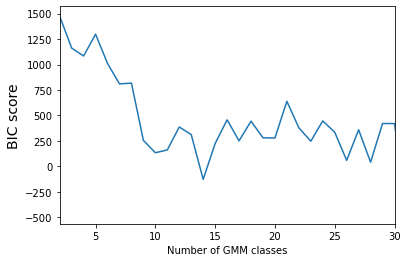

In [36]:
from sklearn import mixture
#First, combine all data in one dataframe and do some clean-up
gw_tot_df.dropna(subset = ["NO2",'Water_Level_Trend(m/yr)'], inplace=True)
gw_tot_df.drop(gw_tot_df[abs(gw_tot_df['Water_Level_Trend(m/yr)']) >5].index, inplace=True)
X = np.concatenate((gw_tot_df['NO2'].to_numpy().reshape((len(gw_tot_df['NO2'].to_numpy()),1)),
                     gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy().reshape((len(gw_tot_df['Water_Level_Trend(m/yr)'].to_numpy()),1)),
                    gw_tot_df['VI_trend'].to_numpy().reshape((len(gw_tot_df['VI_trend'].to_numpy()),1))),
                    axis=1)


#Now do GMM classification - don't know how many classes are optimal, so compute BIC score for N=2-30 classes
bic=np.zeros((30,))
for i in range(30):
    gmm = mixture.GaussianMixture(i+1,covariance_type='full')
    gmm.fit(X)
    Y = gmm.predict(X)
    bic[i]=gmm.bic(X)
fig = plt.figure()
plt.plot(np.arange(2,32,1),bic)
plt.ylabel("BIC score",fontsize=14)
plt.xlabel("Number of GMM classes")
plt.xlim([2,30])

BIC is minimized for 14 GMM classes, but I will use 5 classes to show them more easily in this preliminary analysis.

In [63]:
gmm = mixture.GaussianMixture(8,covariance_type='full')
gmm.fit(X)
Y = gmm.predict(X)
gw_tot_df["Class"]=Y

In [64]:
def find_class(pdname,class_num):
    lat = pdname["Latitude"].to_numpy()
    lon = pdname["Longitude"].to_numpy()
    gw = pdname['Water_Level_Trend(m/yr)'].to_numpy()
    NO2 = pdname["NO2"].to_numpy()
    VI = pdname["VI_trend"].to_numpy()
    cl = pdname['Class'].to_numpy()
    return lat[np.where(cl==class_num)], lon[np.where(cl==class_num)],gw[np.where(cl==class_num)],NO2[np.where(cl==class_num)], VI[np.where(cl==class_num)]

[lat0,lon0,gw0,NO20,VI0] = find_class(gw_tot_df,0)
[lat1,lon1,gw1,NO21,VI1] = find_class(gw_tot_df,1)
[lat2,lon2,gw2,NO22,VI2] = find_class(gw_tot_df,2)
[lat3,lon3,gw3,NO23,VI3] = find_class(gw_tot_df,3)
[lat4,lon4,gw4,NO24,VI4] = find_class(gw_tot_df,4)
[lat5,lon5,gw5,NO25,VI5] = find_class(gw_tot_df,5)
[lat6,lon6,gw6,NO26,VI6] = find_class(gw_tot_df,6)
[lat7,lon7,gw7,NO27,VI7] = find_class(gw_tot_df,7)

<IPython.core.display.Javascript object>


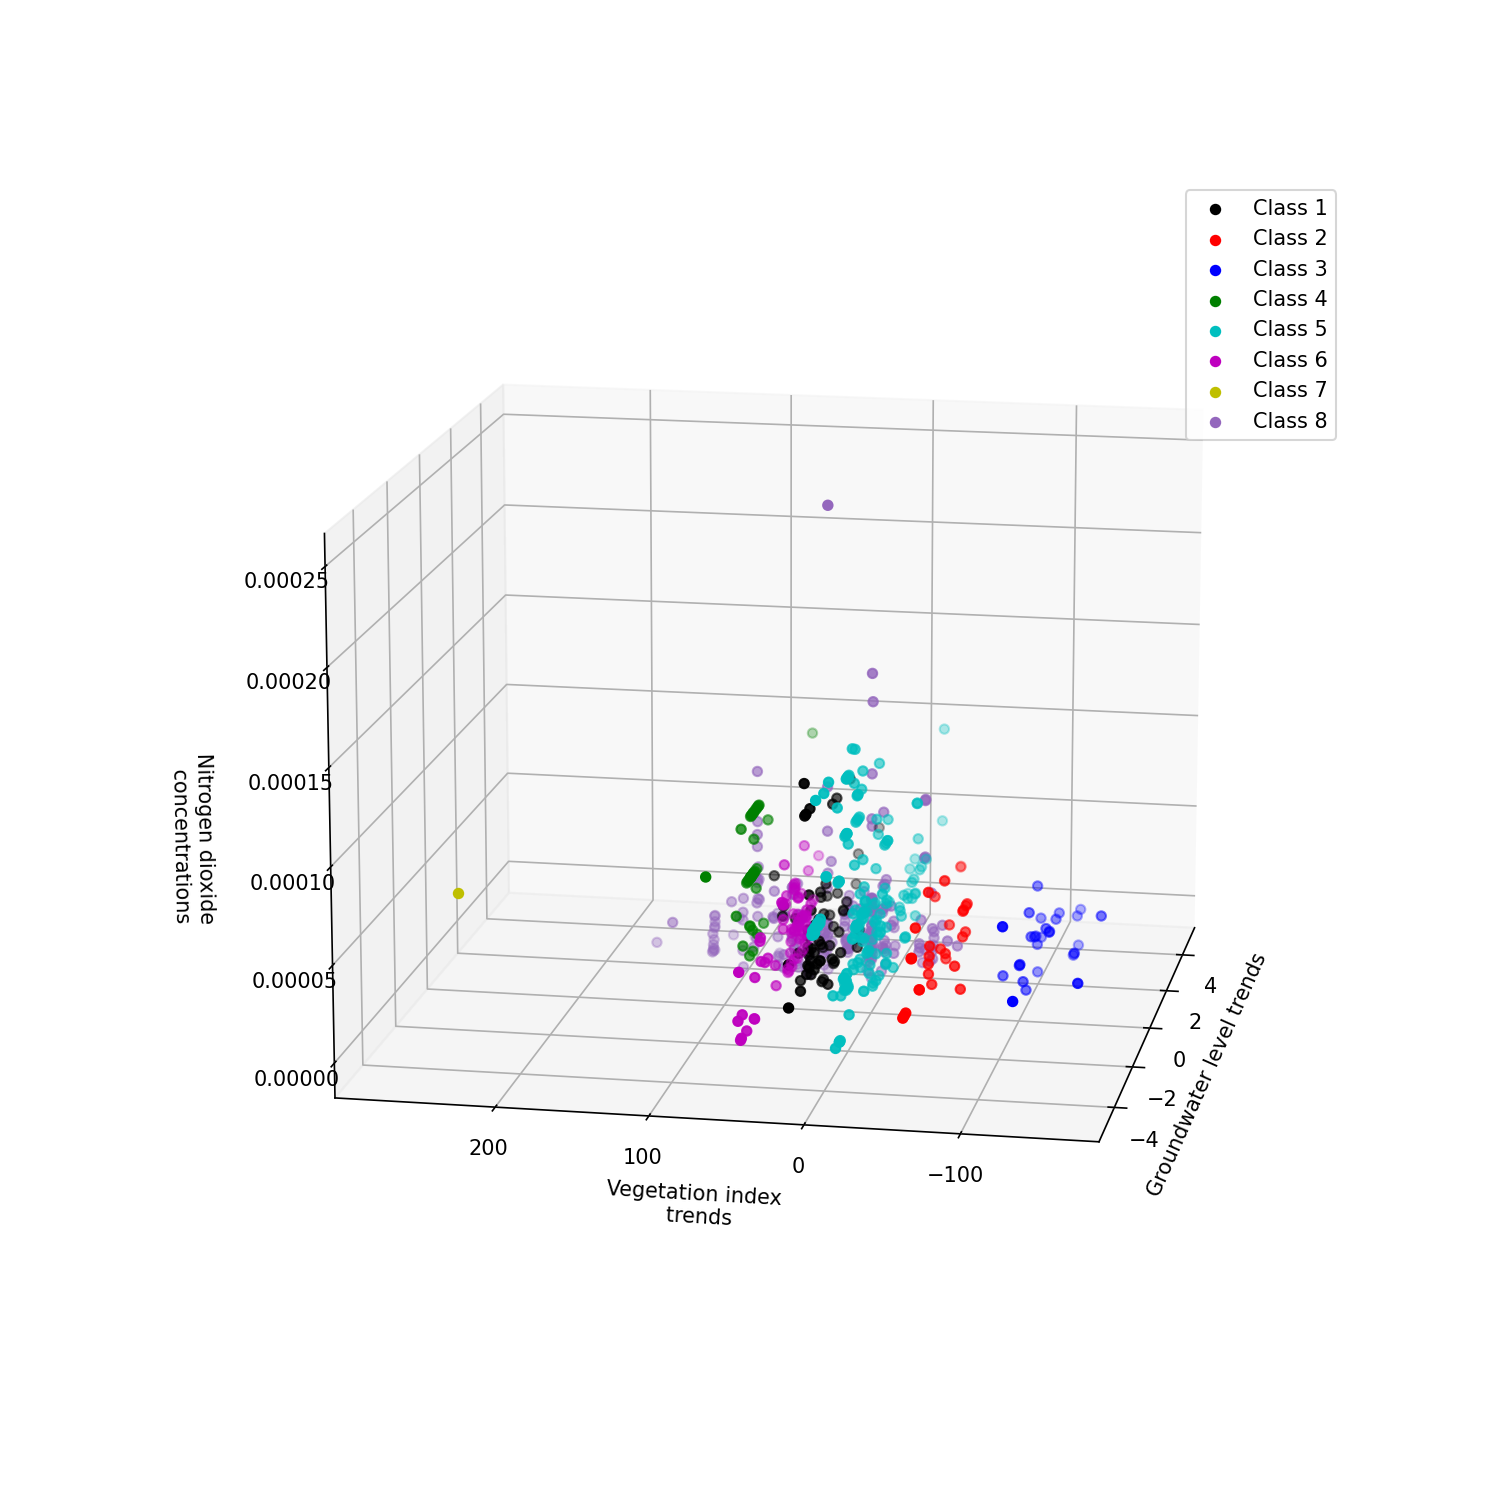

In [69]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax = fig.add_subplot(projection='3d')
ax.scatter(gw0,VI0,NO20,c='k',label='Class 1')
ax.scatter(gw1,VI1,NO21,c='r',label='Class 2')
ax.scatter(gw2,VI2,NO22,c='b',label='Class 3')
ax.scatter(gw3,VI3,NO23,c='g',label='Class 4')
ax.scatter(gw4,VI4,NO24,c='c',label='Class 5')
ax.scatter(gw5,VI5,NO25,c='m',label='Class 6')
ax.scatter(gw6,VI6,NO26,c='y',label='Class 7')
ax.scatter(gw7,VI7,NO27,c='tab:purple',label='Class 8')
ax.set_xlabel('Groundwater level trends',labelpad=2)
ax.set_ylabel('Vegetation index \n trends',labelpad=10)
ax.set_zlabel('Nitrogen dioxide \n concentrations',labelpad=20)
ax.view_init(30, 30)
ax.legend()